# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import datetime

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [4]:
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [6]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [8]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [9]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [11]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [13]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
20731,id_480,Oslo,NaN,481.0,NaN,11.0,"[['Good neighborhood wine bar', 'Oslos best wi...",/Restaurant_Review-g190479-d8591199-Reviews-Ba...,d8591199,1,4.5
47354,id_5555,Barcelona,NaN,5556.0,NaN,9.0,"[['Ok for breakfast', 'fooding1'], ['05/14/201...",/Restaurant_Review-g187497-d6458681-Reviews-Ca...,d6458681,1,4.0
23891,id_20,Hamburg,"['Japanese', 'Seafood', 'Sushi', 'Asian', 'Fus...",21.0,$$$$,492.0,"[['Yummyyyyy', 'Fabulous flavors'], ['12/06/20...",/Restaurant_Review-g187331-d1343437-Reviews-ON...,d1343437,1,4.5
33799,id_436,Athens,"['American', 'Bar', 'Central American', 'Veget...",437.0,$$ - $$$,207.0,"[['Past its prime', 'Nice to be back'], ['11/2...",/Restaurant_Review-g189400-d789069-Reviews-TGI...,d789069,1,4.0
49043,id_38,Zurich,"['European', 'Central European', 'Gluten Free ...",39.0,$$$$,235.0,"[['Amazing experience', 'Dinner Christmas Eve'...",/Restaurant_Review-g188113-d697896-Reviews-Riv...,d697896,1,4.5


Как видим, большинство признаков у нас требует очистки и предварительной обработки.

In [14]:
data[data['Reviews'] == "[[], []]"].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8112 entries, 0 to 49994
Data columns (total 11 columns):
Restaurant_id        8112 non-null object
City                 8112 non-null object
Cuisine Style        4112 non-null object
Ranking              8112 non-null float64
Price Range          1678 non-null object
Number of Reviews    6089 non-null float64
Reviews              8112 non-null object
URL_TA               8112 non-null object
ID_TA                8112 non-null object
sample               8112 non-null int64
Rating               8112 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 760.5+ KB


In [15]:
data['Number of Reviews'].value_counts().sort_index()

2.0       2403
3.0       2042
4.0       1707
5.0       1471
6.0       1258
          ... 
6777.0       1
7575.0       1
7622.0       1
8927.0       1
9660.0       1
Name: Number of Reviews, Length: 1573, dtype: int64

In [16]:
data[(pd.isna(data['Number of Reviews'])) & (data['Reviews'] != "[[], []]")]

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
74,id_74,Prague,"['Cafe', 'European', 'Czech']",2052.0,$,NaN,"[[""Nova' Doba""], ['01/26/2017']]",/Restaurant_Review-g274707-d12032989-Reviews-C...,d12032989,0,0.0
139,id_139,Berlin,NaN,3469.0,NaN,NaN,"[['South American food at its best!'], ['09/05...",/Restaurant_Review-g187323-d4802788-Reviews-Bo...,d4802788,0,0.0
141,id_141,Barcelona,"['Italian', 'Mediterranean', 'Spanish']",4180.0,$$ - $$$,NaN,"[['Real treasure'], ['10/20/2017']]",/Restaurant_Review-g187497-d12530776-Reviews-C...,d12530776,0,0.0
159,id_159,Amsterdam,['Italian'],2767.0,NaN,NaN,"[['Solo: Great restaurant in Museumplein'], ['...",/Restaurant_Review-g188590-d753088-Reviews-Ban...,d753088,0,0.0
246,id_246,London,NaN,8882.0,NaN,NaN,"[['Good service'], ['11/16/2016']]",/Restaurant_Review-g186338-d5244329-Reviews-Pi...,d5244329,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
49764,id_9346,London,"['Italian', 'British']",9355.0,$$ - $$$,NaN,"[['Great little cafe and bakery'], ['01/06/201...",/Restaurant_Review-g186338-d13100127-Reviews-L...,d13100127,1,5.0
49767,id_4359,Barcelona,NaN,4360.0,NaN,NaN,"[['fantastic value and service'], ['03/01/2013']]",/Restaurant_Review-g187497-d1081683-Reviews-Mo...,d1081683,1,5.0
49907,id_1603,Edinburgh,NaN,1609.0,NaN,NaN,"[['Small, Friendly Place on the Mile'], ['11/1...",/Restaurant_Review-g186525-d8814420-Reviews-Bi...,d8814420,1,3.0
49972,id_2009,Prague,"['Cafe', 'Delicatessen', 'Healthy', 'Wine Bar'...",2012.0,$,NaN,"[['Personal expirence'], ['10/27/2017']]",/Restaurant_Review-g274707-d12981295-Reviews-M...,d12981295,1,5.0


In [17]:
for i in data[(pd.isna(data['Number of Reviews'])) & (data['Reviews'] != "[[], []]")].index:

    if pd.isna(data.loc[i]['Reviews']) == False:
        l = len(data.loc[i]['Reviews'].split(','))
        
        if l > 2:
            print(data.loc[i]['Reviews'])

[['Delicious pastries, not so nice interior'], ['08/27/2015']]
[['Poor service, food average, very expensive...'], ['01/02/2008']]
[["Homely feel, I'm an expat and I feel at ho..."], ['06/14/2017']]
[['Nice People, Great Food'], ['03/04/2015']]
[['True local, Cosy and Cheap .. in Prenzlaue...'], ['10/06/2017']]
[['Yummy muffins and doughnuts, and great fre...'], ['01/13/2017']]
[['3,30 for a "pièce" of brownie and mistake...'], ['06/12/2017']]
[['beautiful, fresh pasta made with care'], ['10/29/2016']]
[['1 Minute, Convenient Store wiht friendly s...'], ['04/14/2017']]
[['Simple, inexpensive, tasteful'], ['05/05/2016']]
[['Ok for lunch, but not authentically Italia...'], ['02/18/2012']]
[['Live music, good Persian'], ['09/10/2016']]
[['Popular cafe, especially with Arabic commu...'], ['06/03/2016']]
[['Disappointing, over priced'], ['11/20/2012']]
[['Unfriendly, unhelpful, wrong food'], ['10/28/2015']]
[['Very poor food and service, rundown, shabb...'], ['04/08/2015']]
[['Good authenti

Способ может и не совсем хороший, но вполне подтверждает, что есть 1 отзыв

In [18]:
# заполним пропуски
data['Reviews'] = data['Reviews'].fillna("[[], []]")

In [19]:
number_of_reviews = []

for i in range(data.shape[0]):
    if pd.isna(data.loc[i]['Number of Reviews']) == True:
        if data.loc[i]['Reviews'] == "[[], []]":
            number_of_reviews.append(0)
        else:
            number_of_reviews.append(1)
    else:
        number_of_reviews.append(data.loc[i]['Number of Reviews'])

In [20]:
data['Number of Reviews'] = pd.Series(number_of_reviews)

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    50000 non-null float64
Reviews              50000 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Для удобства заполним пропуски значениями None

In [22]:
#data['Price Range'] = data['Price Range'].apply(lambda x: 'None' if pd.isna(x) else x)

In [23]:
data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x: 'None' if pd.isna(x) else x)

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        50000 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    50000 non-null float64
Reviews              50000 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


добавить признак средней оценки для каждой кухни

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [25]:
# Для примера я возьму столбец Number of Reviews
#data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')

In [26]:
#data['Number_of_Reviews_isNAN'].value_counts()

In [27]:
# Далее заполняем пропуски 0, вы можете попробовать заполнением средним или средним по городу и тд...
#data['Number of Reviews'].fillna(0, inplace=True)

In [28]:
#---- потом можно протестить с медианой или средним

In [29]:
#data.info()

Заполняем пропуски в столбце с кухнями
---


Список всех кухонь

In [30]:
cusines = set()
for row in data['Cuisine Style']:
    if pd.isna(row) == False:
        for cus in row[1:-1].replace("'", '').split(','):
            if cus[0] != ' ':
                cusines.add(cus)
            else:
                cusines.add(cus[1:])
        
cusines.add('None')

Какое среднее кол-во кухонь представлено в одном ресторане

In [31]:
#cusine_counter_m = []
#
#for row in data['Cuisine Style']:
#    if pd.isna(row) == False:
#        cusine_counter_m.append(len(row[1:-1].replace("'", '').split(',')))

In [32]:
#pd.Series(cusine_counter_m).plot(kind='box')

Целесообразне брать медиану, т.к. есть выбросы и среднее будет смещено

In [33]:
#pd.Series(cusine_counter_m).median()

Итого нам надо для каждого пропущенного значения подобрать 3 наиболее часто встречающиеся кухни.  
Будем ориентироваться на города. Посмотрим какие кухни характерны для ресторана каждого города

In [34]:
# составим список всех присутствующих городов
cities = data['City'].unique()

In [35]:
# составим словарь словарей, для дальнейшего анализа какие кухни чаще всего встречаются в городах
# структура следующая: {Город: {Кухня: 0}}

#cusines_in_city = {}
#
#for city in cities:
#    interim_dict = {}
#    
#    for cusine in cusines:
#        interim_dict[cusine] = 0
#        
#    cusines_in_city[city] = interim_dict

In [36]:
# Созданный выше словарь словарей мы наполним значениями. 
# Посчитаем, сколько раз каждая кухня встречается в конкретном городе

#for city in cities:
#    
#    for val in data[data['City'] == city]['Cuisine Style']:
#        
#        if pd.isna(val) == False:
#        
#            for cus in val[1:-1].replace("'", '').split(','):
#                if cus[0] != ' ':
#                    cusines_in_city[city][cus] += 1
#                else:
#                    cusines_in_city[city][cus[1:]] += 1

In [37]:
# Отберем 3 самый популярные кухни для каждого города

#popular_cusines = {}
#
#for city in cities:
#    popular_cus_city = pd.DataFrame(cusines_in_city)['Paris'].sort_values(ascending=False).index[:3]
#    popular_cusines[city] = str(popular_cus_city)[6:-17]

In [38]:
# создадим отдельный столбец с вариантами кухонь, где вместо пропусков будут часто встречаемые
# сначала мы сделаем список, который преобразуем в пандас серию

#cuisine_style_new = []
#
#for i in range(data.shape[0]):
#    if pd.isna(data.loc[i]['Cuisine Style']) == True:
#        cuisine_style_new.append(popular_cusines[data.loc[i]['City']])
#    else:
#        cuisine_style_new.append(data.loc[i]['Cuisine Style'])

In [39]:
# меняем старый солбец на новый
#data['Cuisine Style'] = pd.Series(cuisine_style_new)

In [40]:
#data.info()

### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [41]:
data.nunique(dropna=False)

Restaurant_id        13094
City                    31
Cuisine Style        10732
Ranking              12975
Price Range              4
Number of Reviews     1575
Reviews              41857
URL_TA               49963
ID_TA                49963
sample                   2
Rating                  10
dtype: int64

Интересно, что Restaurant_id имеет 13094 уникальных значений, в то время как ID_TA почти 50 тыс.  
Скорее всего есть рестораны, которые относятся к сетям. Для таких стоит ввести отдельный признак "Принадлежность к сети"

In [42]:
counter_id = data['Restaurant_id'].value_counts()

## Можно заменить на кол-во ресторанов в сети

In [43]:
# создаем признак, где показывается кол-во ресторанов в сети

data['network_restaurant'] = data['Restaurant_id'].apply(lambda x: counter_id[x])

In [44]:
data.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,network_restaurant
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,16
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,10
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,15
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,9
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,14


In [45]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,network_restaurant
10354,id_1630,Lisbon,"['Italian', 'Vegetarian Friendly']",1631.0,$$ - $$$,9.0,[['A great experience close to our guest hous....,/Restaurant_Review-g189158-d12081682-Reviews-L...,d12081682,1,4.5,9
37929,id_4030,Barcelona,['Mediterranean'],4031.0,$$ - $$$,52.0,"[['Good value, great service', 'Amazing Steak ...",/Restaurant_Review-g187497-d5616911-Reviews-Ba...,d5616911,1,4.5,5
19239,id_886,Prague,"['International', 'European', 'Czech', 'Easter...",887.0,$$ - $$$,380.0,"[['Great views over the city and decent food',...",/Restaurant_Review-g274707-d1027079-Reviews-Re...,d1027079,1,4.0,8
12727,id_5634,Madrid,None,5637.0,NaN,8.0,"[[], []]",/Restaurant_Review-g187514-d7714826-Reviews-La...,d7714826,1,3.5,3
42215,id_1332,Zurich,None,1337.0,NaN,9.0,"[['Unexpectedly super!'], ['11/22/2017']]",/Restaurant_Review-g188113-d11829626-Reviews-C...,d11829626,1,3.5,12


#### Возьмем следующий признак "Price Range".

In [46]:
#data['Price Range'].value_counts()

По описанию 'Price Range' это - Цены в ресторане.  
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3  
*Попробуйте сделать обработку этого признака уже самостоятельно!*

In [47]:
# Ваша обработка 'Price Range'
#Готовим столбец Price Range для создания dummies
def price_range_rating (price_range_string):
    if "$$$$" in str(price_range_string):
        return(int(3))
    elif "$$ - $$$" in str(price_range_string):
        return(int(2))
    elif "$" in str(price_range_string):
        return(int(1))
    elif str(0) in str(price_range_string):
        return(int(0))
data['Price Range'] = data['Price Range'].apply(price_range_rating)

#Заполним пропуски наиболее встречаемым значением
data['Price Range'] = data['Price Range'].fillna(2)

In [48]:
#Делаем dummies на основе изменного Price Range
#data = pd.get_dummies(data, columns=['Price Range', ], dummy_na=True)

> Для некоторых алгоритмов МЛ даже для не категориальных признаков можно применить One-Hot Encoding, и это может улучшить качество модели. Пробуйте разные подходы к кодированию признака - никто не знает заранее, что может взлететь.

### Обработать другие признаки вы должны самостоятельно!
Для обработки других признаков вам возможно придется даже написать свою функцию, а может даже и не одну, но в этом и есть ваша практика в этом модуле!     
Следуя подсказкам в модуле вы сможете более подробно узнать, как сделать эти приобразования.

In [49]:
# Добавляем новый признак "Столица - Не столица"
capitals = {'City': [
    'London', 'Paris', 'Madrid', 'Barcelona', 'Berlin', 'Milan', 'Rome', 'Prague',
    'Lisbon', 'Vienna', 'Amsterdam', 'Brussels', 'Hamburg', 'Munich', 'Lyon', 'Stockholm',
    'Budapest', 'Warsaw', 'Dublin', 'Copenhagen', 'Athens', 'Edinburgh', 'Zurich', 'Oporto',
    'Geneva', 'Krakow', 'Oslo', 'Helsinki', 'Bratislava', 'Luxembourg', 'Ljubljana'],
    'Country': [
    'United Kingdom', 'France', 'Spain', 'Spain', 'Germainy', 'Italy', 'Italy', 'Czech Republic',
    'Portugal', 'Austria', 'Netherlands', 'Belgium', 'Germainy', 'Germainy', 'France', 'Sweden',
    'Hungary', 'Poland', 'Ireland', 'Denmark', 'Greece', 'Scotland', 'Switzerland', 'Portugal',
    'Switzerland', 'Poland', 'Norway', 'Finland', 'Slovakia', 'Luxembourg', 'Slovenia'],
    'Is capital': [1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]
}
capitals_list = []
for i,j in zip(capitals['City'], capitals['Is capital']):
    if j == 1:
        capitals_list.append(i)
def capital_sign(city_string):
    if city_string in capitals_list:
        return(1)
    else:
        return(0)
data['Is_capital'] = data['City'].apply(capital_sign)

In [50]:
#Делаем даммиз на основании нового признака
#data = pd.get_dummies(data, columns=['Is_capital', ], dummy_na=True)

In [51]:
#Создаем новый признак из разницы между датами отзывов

# Вычленяем из строки даты и записываем в отдельный столбец
data['Number of Reviews'].fillna(0, inplace=True)

#Заполняем наны в столбце Reviews
data['Reviews'].fillna('[[], []]', inplace=True)

def data_extract(reviews_str):
    pattern = re.compile('\d\d\W\d\d\W\d\d\d\d')
    tmp_data = pattern.findall(reviews_str)
    return(tmp_data)

data['Data_Reviews'] = data['Reviews'].apply(data_extract)

#Резделим даты отзывов на два столбца. Пригодится и для следующего задания
def data_reviews_separate_1(data_reviews_string):
    tmp = 0
    if len(data_reviews_string) == 0:
        tmp = 0
    else:
        tmp = data_reviews_string[0]
    return(tmp)

def data_reviews_separate_2(data_reviews_string):
    tmp = 0
    if len(data_reviews_string) == 0:
        tmp = 0
    elif len(data_reviews_string) == 1:
        tmp = 0
    elif len(data_reviews_string) == 2:
        tmp = data_reviews_string[1]
    return(tmp)

data['Data_Reviews_1'] = data['Data_Reviews'].apply(data_reviews_separate_1)
data['Data_Reviews_2'] = data['Data_Reviews'].apply(data_reviews_separate_2)

#Преобразовываем столбцы Data_Reviews_ в формат datetime
data['Data_Reviews_1'] = data['Data_Reviews_1'].apply(lambda x: pd.to_datetime(x) if x != 0 else False)
data['Data_Reviews_2'] = data['Data_Reviews_2'].apply(lambda x: pd.to_datetime(x) if x != 0 else False) 

# Вычисляем разницу в днях между отзывами, чистим значения от None и преобразовываем в int
def data_delta(Data_Reviews_item):
    if (len(Data_Reviews_item) == 0) or (len(Data_Reviews_item) == 1):
        tmp = 0
    else:
        tmp = pd.to_datetime(
            Data_Reviews_item[0]) - pd.to_datetime(Data_Reviews_item[1])

    if tmp != 0:
        return(str(tmp))


def data_delta_to_int(data_delta_item):
    tmp = str(data_delta_item)
    if '-' in tmp:
        tmp1 = tmp[1:-15]
    elif 'None' in tmp:
        tmp1 = '0'
    else:
        tmp1 = tmp[:-14]
    return(int(tmp1))


data['Data_Delta'] = data['Data_Reviews'].apply(data_delta)
data['Data_Delta'] = data['Data_Delta'].apply(data_delta_to_int)


#Убираем пропуски из столбцов Data_Reviews_х
def error_date_to_zero(data_string):
    if data_string == False:
        return(int(0))
    else:
        return(data_string)

data['Data_Reviews_1'] = data['Data_Reviews_1'].apply(error_date_to_zero)
data['Data_Reviews_2'] = data['Data_Reviews_2'].apply(error_date_to_zero)

Добавим признак - кол-во кухонь предоставленных в ресторане

In [52]:
def cusine_counter(row):
    cusine = []
    for cus in row[1:-1].replace("'", '').split(','):
        cusine.append(cus)
    return len(cusine)

In [53]:
data['cusine_count'] = data['Cuisine Style'].apply(cusine_counter)

Добавим признак - кол-во ресторанов в городе

In [54]:
quantity_rest = data['City'].value_counts()

In [55]:
data['quantity'] = data['City'].apply(lambda x: quantity_rest[x])

Следующий признак - средняя оценка в городе  
*Можно потом поменять на отклонение от средней оценки, если не устроят результаты*

In [56]:
mean_rating_in_city = data.groupby('City')['Rating'].mean()

In [57]:
data['mean_rating'] = data['City'].apply(lambda x: mean_rating_in_city[x])

Признак - среднее кол-во отзывов о ресторане в городе

In [58]:
mean_number_reviews_in_city = data.groupby('City')['Number of Reviews'].mean()

In [59]:
data['mean_reviews'] = data['City'].apply(lambda x: mean_number_reviews_in_city[x])

Создадим даммиз по кухням

In [60]:
cuisines_rating = {}

for cus in cusines:
    cu_rating = data[data['Cuisine Style'].str.contains(cus)]['Rating'].median()
    cuisines_rating[cus] = cu_rating

In [61]:
def find_cuisine(row):
    if cus in row:
        return cuisines_rating[cus]
    return 0

In [62]:
for cus in list(cusines):
    data[cus] = data['Cuisine Style'].apply(find_cuisine)

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение признака

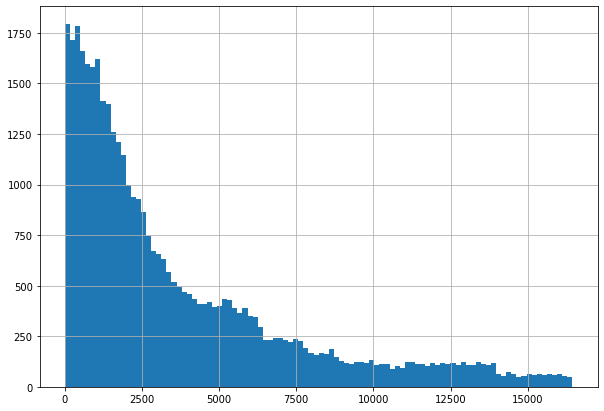

In [63]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

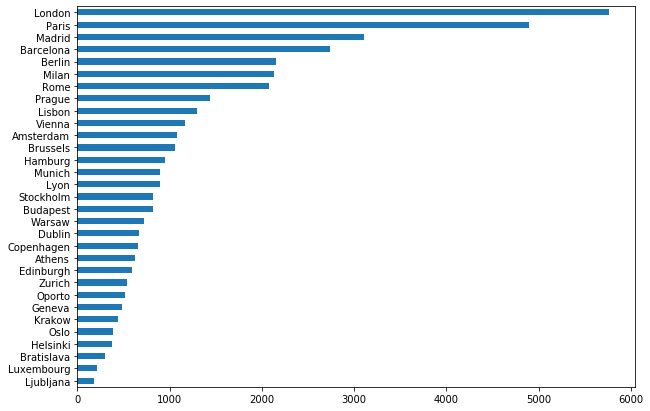

In [64]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

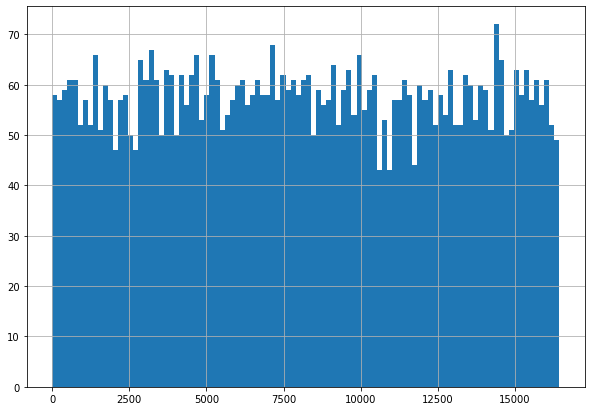

In [65]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

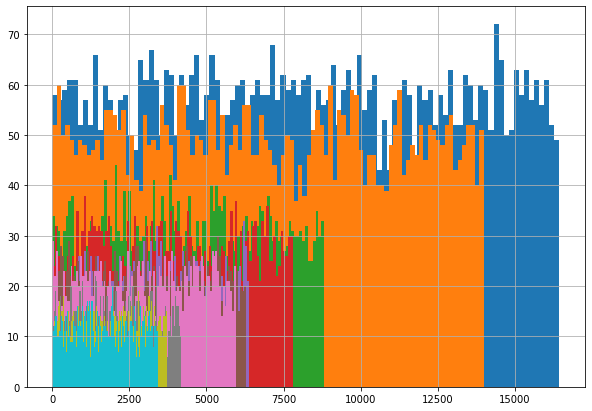

In [66]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


In [67]:
data['Ranking_global'] = data['Ranking'] / data['City'].apply(lambda x: quantity_rest[x])

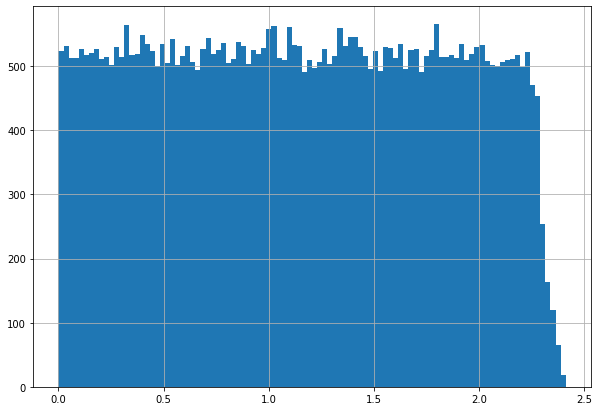

In [68]:
data['Ranking_global'].hist(bins=100)

### Посмотрим распределение целевой переменной

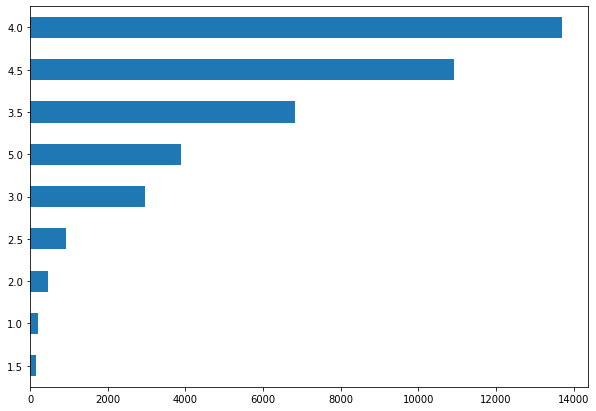

In [69]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

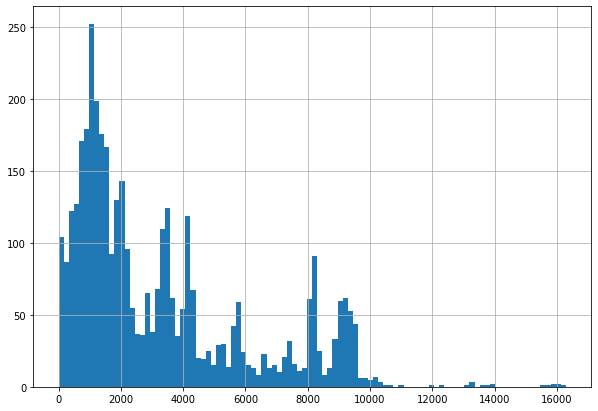

In [70]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

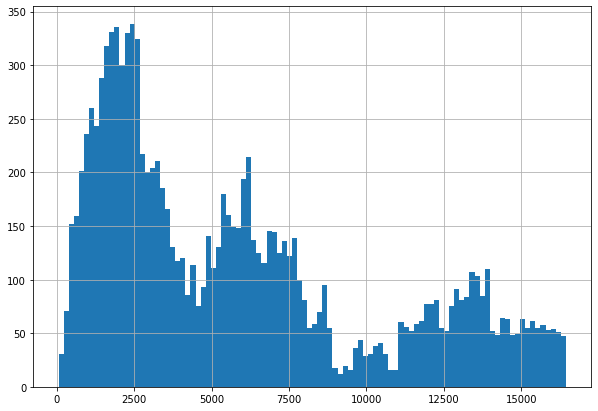

In [71]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

In [72]:
#plt.rcParams['figure.figsize'] = (15,10)
#sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

#### Запускаем и проверяем что получилось

In [95]:
#df_preproc = preproc_data(data)
#df_preproc.sample(10)

In [74]:
#df_preproc.info()

In [87]:
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
#df_output.drop(object_columns, axis = 1, inplace=True)

In [103]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)
X = X.drop(object_columns, axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [105]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [106]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 148), (40000, 148), (40000, 138), (32000, 138), (8000, 138))

# Model 
Сам ML

In [80]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [107]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [108]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   23.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [109]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.202393125


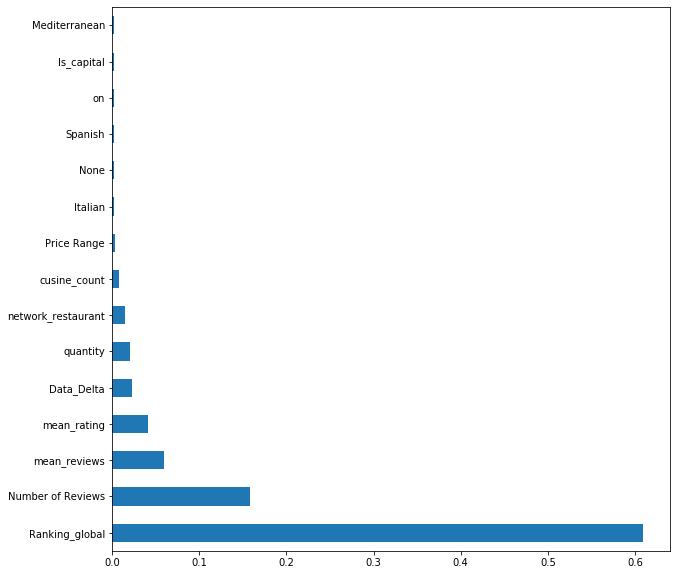

In [102]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [86]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 149 entries, Restaurant_id to Ranking_global
dtypes: float64(134), int64(6), object(9)
memory usage: 56.8+ MB


In [85]:
f=f

NameError: name 'f' is not defined

# Submission
Если все устраевает - готовим Submission на кагл

In [ ]:
test_data.sample(10)

In [ ]:
test_data = test_data.drop(['Rating'], axis=1)

In [ ]:
sample_submission

In [ ]:
predict_submission = model.predict(test_data)

In [ ]:
predict_submission

In [ ]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!


# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [ ]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

In [ ]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['Restaurant_id','ID_TA',], axis = 1, inplace=True)
    
    
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
    df_output['Number of Reviews'].fillna(0, inplace=True)
    # тут ваш код по обработке NAN
    # ....
    
    
    # ################### 3. Encoding ############################################################## 
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    #df_output = pd.get_dummies(df_output, columns=[ 'City',], dummy_na=True)
    
    # ################### 4. Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    #Готовим столбец Price Range для создания dummies
    def price_range_rating (price_range_string):
        if "$$$$" in str(price_range_string):
            return(int(3))
        elif "$$ - $$$" in str(price_range_string):
            return(int(2))
        elif "$" in str(price_range_string):
            return(int(1))
        elif str(0) in str(price_range_string):
            return(int(0))
    df_output['Price Range'] = df_output['Price Range'].apply(price_range_rating)
    #Делаем dummies на основе изменного Price Range
    df_output = pd.get_dummies(df_output, columns=['Price Range', ], dummy_na=True)
    
    # Добавляем новый признак "Столица - Не столица"
    capitals = {'City': [
    'London', 'Paris', 'Madrid', 'Barcelona', 'Berlin', 'Milan', 'Rome', 'Prague',
    'Lisbon', 'Vienna', 'Amsterdam', 'Brussels', 'Hamburg', 'Munich', 'Lyon', 'Stockholm',
    'Budapest', 'Warsaw', 'Dublin', 'Copenhagen', 'Athens', 'Edinburgh', 'Zurich', 'Oporto',
    'Geneva', 'Krakow', 'Oslo', 'Helsinki', 'Bratislava', 'Luxembourg', 'Ljubljana'],
    'Country': [
    'United Kingdom', 'France', 'Spain', 'Spain', 'Germainy', 'Italy', 'Italy', 'Czech Republic',
    'Portugal', 'Austria', 'Netherlands', 'Belgium', 'Germainy', 'Germainy', 'France', 'Sweden',
    'Hungary', 'Poland', 'Ireland', 'Denmark', 'Greece', 'Scotland', 'Switzerland', 'Portugal',
    'Switzerland', 'Poland', 'Norway', 'Finland', 'Slovakia', 'Luxembourg', 'Slovenia'],
    'Is capital': [1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]
    }
    capitals_list = []
    for i,j in zip(capitals['City'], capitals['Is capital']):
        if j == 1:
            capitals_list.append(i)
    def capital_sign(city_string):
        if city_string in capitals_list:
            return(1)
        else:
            return(0)
    df_output['Is_capital'] = df_output['City'].apply(capital_sign)
    #Делаем даммиз на основании нового признака
    df_output = pd.get_dummies(df_output, columns=['Is_capital', ], dummy_na=True)
    

    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    df_output = pd.get_dummies(df_output, columns=[ 'City',], dummy_na=True)
    
    #Создаем новый признак из разницы между датами отзывов

    # Вычленяем из строки даты и записываем в отдельный столбец
    df_output['Number of Reviews'].fillna(0, inplace=True)
    #Заполняем наны в столбце Reviews
    df_output['Reviews'].fillna('[[], []]', inplace=True)
    def data_extract(reviews_str):
        pattern = re.compile('\d\d\W\d\d\W\d\d\d\d')
        tmp_data = pattern.findall(reviews_str)
        return(tmp_data)
    df_output['Data_Reviews'] = df_output['Reviews'].apply(data_extract)
    #Резделим даты отзывов на два столбца. Пригодится и для следующего задания
    def data_reviews_separate_1(data_reviews_string):
        tmp = 0
        if len(data_reviews_string) == 0:
            tmp = 0
        else:
            tmp = data_reviews_string[0]
        return(tmp)

    def data_reviews_separate_2(data_reviews_string):
        tmp = 0
        if len(data_reviews_string) == 0:
            tmp = 0
        elif len(data_reviews_string) == 1:
            tmp = 0
        elif len(data_reviews_string) == 2:
            tmp = data_reviews_string[1]
        return(tmp)

    df_output['Data_Reviews_1'] = df_output['Data_Reviews'].apply(data_reviews_separate_1)
    df_output['Data_Reviews_2'] = df_output['Data_Reviews'].apply(data_reviews_separate_2)

    #Преобразовываем столбцы Data_Reviews_ в формат datetime
    df_output['Data_Reviews_1'] = df_output['Data_Reviews_1'].apply(lambda x: pd.to_datetime(x) if x != 0 else False)
    df_output['Data_Reviews_2'] = df_output['Data_Reviews_2'].apply(lambda x: pd.to_datetime(x) if x != 0 else False) 

    # Вычисляем разницу в днях между отзывами, чистим значения от None и преобразовываем в int
    def data_delta(Data_Reviews_item):
        if (len(Data_Reviews_item) == 0) or (len(Data_Reviews_item) == 1):
            tmp = 0
        else:
            tmp = pd.to_datetime(
                Data_Reviews_item[0]) - pd.to_datetime(Data_Reviews_item[1])

        if tmp != 0:
            return(str(tmp))


    def data_delta_to_int(data_delta_item):
        tmp = str(data_delta_item)
        if '-' in tmp:
            tmp1 = tmp[1:-15]
        elif 'None' in tmp:
            tmp1 = '0'
        else:
            tmp1 = tmp[:-14]
        return(int(tmp1))


    df_output['Data_Delta'] = df_output['Data_Reviews'].apply(data_delta)
    df_output['Data_Delta'] = df_output['Data_Delta'].apply(data_delta_to_int)


    #Убираем пропуски из столбцов Data_Reviews_х
    def error_date_to_zero(data_string):
        if data_string == False:
            return(int(0))
        else:
            return(data_string)
    df_output['Data_Reviews_1'] = df_output['Data_Reviews_1'].apply(error_date_to_zero)
    df_output['Data_Reviews_2'] = df_output['Data_Reviews_2'].apply(error_date_to_zero)
    
    #Создаем даммиз из столбца с набором кухонь в ресторане

    #Собираем множество из значений столбца data['Cuisine']
    pd.options.mode.chained_assignment = None  # default='warn'
    cuisine_set = set()
    def clearing_string(cuisine_str):
        tmp = str(cuisine_str).replace('\'',"")
        tmp = tmp.replace(' ',"")
        tmp = tmp[1:-1]
        tmp_lst = tmp.split(',')
        for i in range(0,len(tmp_lst)):
            cuisine_set.add(tmp_lst[i])
        return(cuisine_set)
    df_output['Cuisine Style'].apply(clearing_string)
    cuisine_set.remove('a')

    #Создаем даммиз из столбца с набором кухонь в ресторане

    #Собираем множество из значений столбца data['Cuisine']
    pd.options.mode.chained_assignment = None  # default='warn'
    cuisine_set = set()
    def clearing_string(cuisine_str):
        tmp = str(cuisine_str).replace('\'',"")
        tmp = tmp.replace(' ',"")
        tmp = tmp[1:-1]
        tmp_lst = tmp.split(',')
        for i in range(0,len(tmp_lst)):
            cuisine_set.add(tmp_lst[i])
        return(cuisine_set)
    df_output['Cuisine Style'].apply(clearing_string)
    cuisine_set.remove('a')


    #Для начала преобразуем элементы столбца Cuisine из строк в списки
    def cuisine_convert_to_list (cuisine_str):
        tmp = str(cuisine_str).replace('\'',"")
        tmp = tmp.replace(' ',"")
        tmp = tmp[1:-1]
        tmp_lst = tmp.split(',')
        return(tmp_lst)
    #Преобразовываем элементы слобца 'Cuisine' из строк в списки
    df_output['Cuisine Style'] = df_output['Cuisine Style'].apply(cuisine_convert_to_list)

    #Создадим словарь из ключей - названий кухнь с нулевыми начениями
    cuisine_list = list(cuisine_set)
    cuisine_df = pd.DataFrame(cuisine_list)
    cuisine_df = cuisine_df[0].sort_values()
    cuisine_df = cuisine_df.reset_index(drop = True)
    #Добавляем новые столбцы по именам кухонь для будущих признаков
    for i in range (0, len(cuisine_list)):
        df_output[cuisine_df[i]] = int(0)

    #Проверяем есть ли имя столбца, одноименного с именем кухни, в строке "Cuisine". Если да, в соотв. ячеку столбца с именем кухни ставим 1
    for i in range (0, len(cuisine_df)):
        for j in range (0,len(df_output)):
            if cuisine_df[i] in df_output['Cuisine Style'][j]:
                df_output[cuisine_df[i]][j] = int(1)

# ################### 5. Clean #################################################### 
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    return df_output